In [1]:
from config import *
from utils import *
from models import *
from train import *
from inference import *
import pickle
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/dlb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Data Preprocessing

In [2]:
print(device)

cuda


In [3]:
# !pip install datasets

In [4]:
import nltk
from datasets import load_dataset

# Ensure that the punkt tokenizer is downloaded
nltk.download('punkt')

def process_text(text):
    # Tokenize the text into sentences
    sentences = nltk.tokenize.sent_tokenize(text)
    # Prepare to collect pairs
    pairs = []
    # Iterate through the sentences and pair them, ensuring no internal tabs
    for i in range(1, len(sentences)):
        # Replace internal tabs in each sentence to avoid confusion in the output format
        sentence1 = sentences[i-1].replace('\t', ' ')
        sentence2 = sentences[i].replace('\t', ' ')
        pair = f"{sentence1}\t{sentence2}"
        pairs.append(pair)
    return pairs

def load_huggingface_data(dataset):
   
    # File to save the pairs
    with open('output_pairs.txt', 'w') as file:
        # Process each text entry in the dataset
        for text in dataset['text']:
            # Get pairs from the current text
            pairs = process_text(text)
            # Write each pair to the file
            for pair in pairs:
                file.write(pair + '\n')

dataset = load_dataset("Amirkid/MedQuad-dataset", split='train')
load_huggingface_data(dataset)

/home/dlb/anaconda3/envs/NLU/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/dlb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Define path to new file
datafile = os.path.join(corpus, "output_pairs.txt")

In [6]:
conversation = read_conversation_from_file(datafile)

In [7]:
len(conversation)

159770

In [8]:
def max_word_count_in_pairs(conversation):
    max_length = 0  # Initialize the maximum length counter
    for index, (question, answer) in enumerate(conversation, start=1):
        # Calculate word count for the question
        question_length = len(question.split())
        # Calculate word count for the answer
        answer_length = len(answer.split())
        
        # Update the maximum word count if the current question or answer has more words
        if question_length > max_length:
            max_length = question_length
        if answer_length > max_length:
            max_length = answer_length

    return max_length

In [9]:
max_word_count_in_pairs(conversation)

753

In [10]:
for index, (question, answer) in enumerate(conversation, start=1):
    print(f"{index}. {question}")
    print(f"   {answer}")
    if index == 10:
        break

1. Any part of your neck  muscles, bones, joints, tendons, ligaments, or nerves  can cause neck problems.
   Neck pain is very common.

2. Neck pain is very common.
   Pain may also come from your shoulder, jaw, head, or upper arms.

3. Pain may also come from your shoulder, jaw, head, or upper arms.
   Muscle strain or tension often causes neck pain.

4. Muscle strain or tension often causes neck pain.
   The problem is usually overuse, such as from sitting at a computer for too long.

5. The problem is usually overuse, such as from sitting at a computer for too long.
   Sometimes you can strain your neck muscles from sleeping in an awkward position or overdoing it during exercise.

6. Sometimes you can strain your neck muscles from sleeping in an awkward position or overdoing it during exercise.
   Falls or accidents, including car accidents, are another common cause of neck pain.

7. Falls or accidents, including car accidents, are another common cause of neck pain.
   Whiplash, a s

## 2 . Data TOkenization & Batching

In [11]:
print(corpus)
print(corpus_name)
print(datafile)
print(save_dir)
MAX_LENGTH = 100
print(MAX_LENGTH)

data/MedQuad
MedQuad
data/MedQuad/output_pairs.txt
model
100


In [12]:
def loadPrepareData(corpus, corpus_name, datafile, MAX_LENGTH):
    try:
        print("Start preparing training data ...")
        voc, pairs = readVocs(datafile, corpus_name)
        print("Read {!s} sentence pairs".format(len(pairs)))
        pairs = filterPairs(pairs, MAX_LENGTH)
        print("Trimmed to {!s} sentence pairs".format(len(pairs)))
        print("Counting words...")
        for pair in pairs:
            voc.addSentence(pair[0])
            voc.addSentence(pair[1])
        print("Counted words:", voc.num_words)
        return voc, pairs
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

voc, pairs = loadPrepareData(corpus, corpus_name, datafile, MAX_LENGTH)

Start preparing training data ...
Reading lines...
Read 159770 sentence pairs
Trimmed to 158235 sentence pairs
Counting words...
Counted words: 29126


In [13]:
print(voc.word2index.get('to', UNK_token))
print(pairs[0])

72
['any part of your neck muscles bones joints tendons ligaments or nerves can cause neck problems .', 'neck pain is very common .']


In [14]:
voc_filename = os.path.join( save_dir,'voc.pkl' ) # Name of the file to save the Voc object

# Save the Voc object to a file
with open(voc_filename, 'wb') as voc_file:
    pickle.dump(voc, voc_file)

print(f"Vocabulary object saved to {voc_filename}")

Vocabulary object saved to model/voc.pkl


In [15]:
# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

Trimmed from 158235 pairs to 158235, 1.0000 of total


In [16]:
training_pairs, validation_pairs, testing_pairs = split_data(pairs, train_percent=0.90, validation_percent=0.05, test_percent=0.05)
print(f"Training Pairs: {len(training_pairs)}")
print(f"Validation Pairs: {len(validation_pairs)}")
print(f"Testing Pairs: {len(testing_pairs)}")

Training Pairs: 142411
Validation Pairs: 7911
Testing Pairs: 7913


## 3.  Modeling

In [17]:
# Initialize models and optimizers
embedding = nn.Embedding(voc.num_words, hidden_size).to(device)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout).to(device)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout).to(device)

In [18]:
# Initialize optimizers after models are assigned to device
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate_en)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate_de)

if loadFilename:
    checkpoint = torch.load(loadFilename, map_location=device)
    encoder.load_state_dict(checkpoint['en'])
    decoder.load_state_dict(checkpoint['de'])
    encoder_optimizer.load_state_dict(checkpoint['en_opt'])
    decoder_optimizer.load_state_dict(checkpoint['de_opt'])
    embedding.load_state_dict(checkpoint['embedding'])
    voc.__dict__ = checkpoint['voc_dict']

/home/dlb/anaconda3/envs/NLU/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 4. Training

In [19]:
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()
# Training iterations
print("Starting Training!")
model_metrices = trainIters(model_name, voc, training_pairs, validation_pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename, PAD_token, SOS_token, UNK_token, EOS_token,device,teacher_forcing_ratio)

Starting Training!
Initializing ...
Training...
Iteration: 100; Percent complete: 0.7%; Training loss: 6.6958; Perplexity: 438.0811
Validation Loss: 6.3367; Validation Perplexity: 564.9254
Iteration: 200; Percent complete: 1.3%; Training loss: 6.0749; Perplexity: 375.1767
Validation Loss: 6.2115; Validation Perplexity: 498.4702
Iteration: 300; Percent complete: 2.0%; Training loss: 5.9051; Perplexity: 280.6719
Validation Loss: 6.2229; Validation Perplexity: 504.1766
Iteration: 400; Percent complete: 2.7%; Training loss: 5.7320; Perplexity: 382.3290
Validation Loss: 6.1987; Validation Perplexity: 492.0939
Iteration: 500; Percent complete: 3.3%; Training loss: 5.5975; Perplexity: 181.3736
Validation Loss: 6.0808; Validation Perplexity: 437.3768
Iteration: 600; Percent complete: 4.0%; Training loss: 5.4940; Perplexity: 347.6152
Validation Loss: 6.1316; Validation Perplexity: 460.1536
Iteration: 700; Percent complete: 4.7%; Training loss: 5.3609; Perplexity: 134.6895
Validation Loss: 6.039

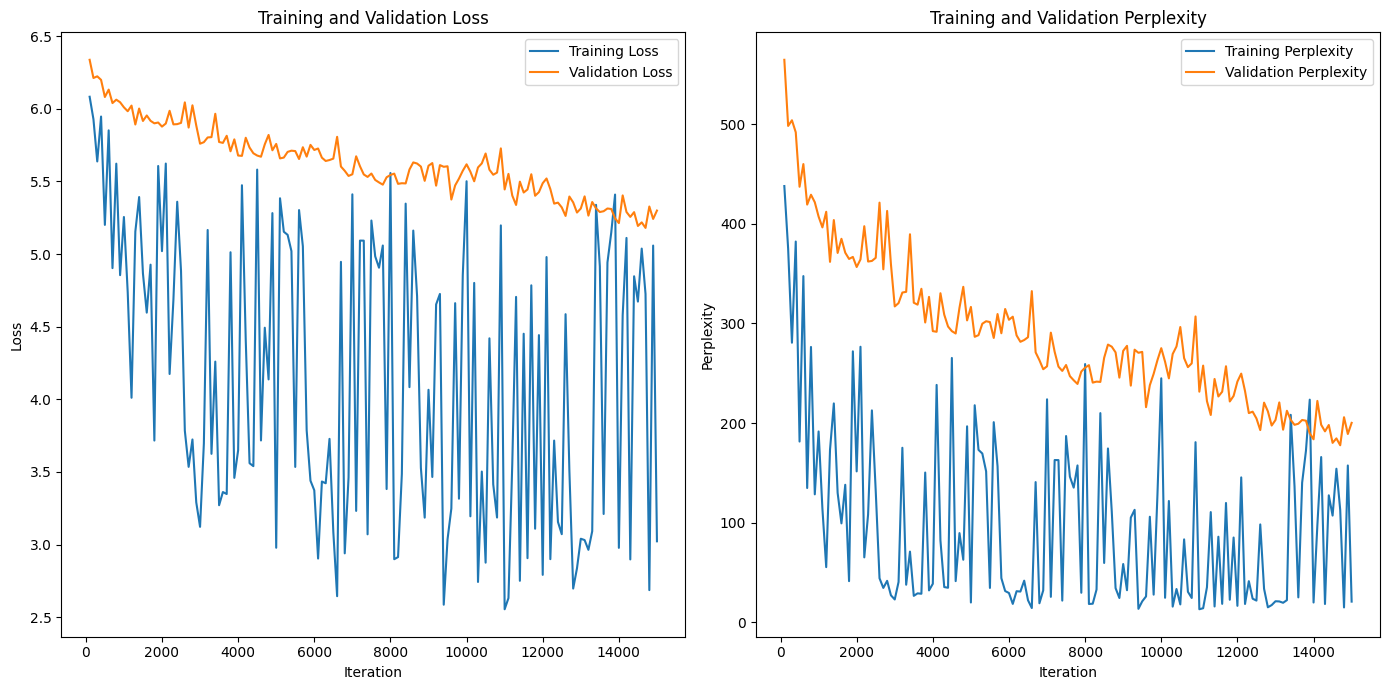

In [20]:
# Data dictionary containing training and validation metrics
data = model_metrices

# Extracting data for plotting
iterations = [d['Iteration'] for d in data]
training_losses = [d['Training loss'] for d in data]
validation_losses = [d['Validation loss'] for d in data]
training_perplexities = [d['Training Perplexity'] for d in data]
validation_perplexities = [d['Validation Perplexity'] for d in data]

# Plotting the losses
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(iterations, training_losses, label='Training Loss')
plt.plot(iterations, validation_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the perplexities
plt.subplot(1, 2, 2)
plt.plot(iterations, training_perplexities, label='Training Perplexity')
plt.plot(iterations, validation_perplexities, label='Validation Perplexity')
plt.xlabel('Iteration')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()

plt.tight_layout()
plt.show()



## 5. Inference 

In [22]:
# Function to load the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    return checkpoint

# Load the best model
checkpoint_path = os.path.join(save_dir, model_name, corpus_name, f'best_model_val_per.tar')
checkpoint = load_checkpoint(checkpoint_path)
# print(checkpoint)

#Load Tokenizer
voc1 = Voc(corpus_name)
voc1.__dict__ = checkpoint['voc_dict']

embedding = nn.Embedding(voc1.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc1.num_words, decoder_n_layers, dropout)
encoder.load_state_dict(checkpoint['en'])
decoder.load_state_dict(checkpoint['de'])

# Move models to the appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)

# Ensure models are in evaluation mode
encoder.eval()
decoder.eval()

LuongAttnDecoderRNN(
  (embedding): Embedding(29126, 512)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(512, 512, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=29126, bias=True)
  (attn): Attn()
)

In [28]:

# Assuming 'conversation' is defined and 'searcher', 'voc' are properly initialized
eval_conversations = testing_pairs[:20]  # Using a subset of 100 conversations for evaluation

total_bleu_score = 0
total_bleu_score_gs = 0
for i, (question, actual_answer) in enumerate(eval_conversations, start=1):
    # Ensure evaluateInput is called with the correct arguments

    generated_response = evaluate(encoder, decoder, question, voc1,PAD_token,SOS_token, UNK_token, EOS_token, device, max_length=100)  # Now correctly passing 'voc'
    bleu_score= calculate_bleu_score([actual_answer], generated_response)
    total_bleu_score += bleu_score
    print(f"----------------------------------------------------------------------------------------------------\n")
    print(f"Q: {question}")
    print(f"Actual Ans: {actual_answer}")
    print(f"Generated Ans: {generated_response}")
    print(f"BLEU Score: {bleu_score}\n")

average_bleu_score = total_bleu_score / len(eval_conversations)

print(f"Average BLEU Score over {len(eval_conversations)} conversations: {average_bleu_score}")

----------------------------------------------------------------------------------------------------

Q: what are the signs and symptoms of temporal epilepsy familial ?
Actual Ans: the human phenotype ontology provides the following list of signs and symptoms for temporal epilepsy familial .
Generated Ans: the human phenotype ontology provides the following list of signs and symptoms for familial hemiplegic .
BLEU Score: 0.7708186875078075

----------------------------------------------------------------------------------------------------

Q: scientists also examine medicines approved to treat other diseases to see they might be effective in people with alzheimers .
Actual Ans: the most promising interventions are tested in testtube and animal studies to make sure they are safe and effective .
Generated Ans: the risk of the the and the and the and and . and .
BLEU Score: 8.676910262183261e-232

-------------------------------------------------------------------------------------------